In [2]:
%matplotlib inline

Data analysis process for the titanic data.

Step 1 : Data collection

Data here is already collected in a csv which would be the input to this project.


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

titanic_data_org = pd.read_csv("/Users/indur/Downloads/titanic_data.csv")
titanic_data = titanic_data_org.copy(deep=True)


Step 2 : Data cleaning

1.Looking at the data, I can see that for a few people in the data set, age is missing which is filled as NAN. 

For this project, I would like to fill missing age with  mean age (which is just an assumption and not computed with any detailed algotithm).


In [4]:
mean_age = titanic_data_org["Age"].dropna().mean()
titanic_data_org["Age"] = titanic_data_org["Age"].fillna(mean_age)


2.Rearrange names in a common addressable format for easy readability since there are multiple formats in which the names are represented.

In [5]:
def rearrange_name(str):
    arr = str.split(",")
    if len(arr) == 2:
        return arr[1] + " " + arr[0]
    elif len(arr) == 1:
        return str
   
titanic_data_org["Name"] = titanic_data_org["Name"].apply(rearrange_name)


3.Some of the passengers have a fare 0 against them. Since it could be valid (for some reason, they got a free trip) , the analysis will include them as passengers who actually paid nothing for the trip.

3.Analysis of data:
    
    Questions :
        1. Did age have a role to play in whether a passenger escaped ?
        2. What was the average fare paid across the different classes ?
        3. What was the distribution of surival rate based on embarkment and class ?
        4. What factors made people more likely to survive?
        
The following section will try to answer most of the questions posted above.

Did age have a role to play in whether a passenger escaped ?
To do this, I assume that if we see a strong correlation between a person age and survival , then we can assume that age has a role to play .
However for calculation pearsons R , only rows with that orginally had a non nil age should be considered.


In [6]:
finite_age_titanic_data = titanic_data[np.isfinite(titanic_data['Age'])].copy(deep=True)
age_series =  finite_age_titanic_data['Age']

survived_series =  finite_age_titanic_data['Survived']
p_r = age_series.corr(survived_series,method='pearson')

print p_r

-0.0772210945722


Since pearsons r is -0.08 . 
Since the value is very close to 0, there is very little negative correlation between age and survival. This is is so small, we can assume solely on this calculation that age had no role to play in increasing a persons chance to escape.

If we try to look at Age data further, the distribution of age of people who survived vs not survived would look like this:




In [7]:
labels = [ "{0} - {1}".format(i, i + 9) for i in range(0, 100, 10) ]
finite_age_titanic_data['age_group'] = pd.cut(finite_age_titanic_data['Age'], range(0, 106, 10), right=True, labels=labels)
finite_age_titanic_data.groupby(['Survived','age_group']).size().groupby(level=1).apply(lambda x:  x/float(x.sum()))
#not sure how to label the count column . The third column represents the distribution of every agen group again survived or not

Survived  age_group
0         0 - 9        0.406250
          10 - 19      0.617391
          20 - 29      0.634783
          30 - 39      0.554839
          40 - 49      0.616279
          50 - 59      0.595238
          60 - 69      0.764706
          70 - 79      0.800000
1         0 - 9        0.593750
          10 - 19      0.382609
          20 - 29      0.365217
          30 - 39      0.445161
          40 - 49      0.383721
          50 - 59      0.404762
          60 - 69      0.235294
          70 - 79      0.200000
dtype: float64

This data shows that 63% of people between the age 20 - 29 died .This could be because they gave their place for children and others in the lifeboat. There could also be other factors that could have an influence on the output.

Also, children who are younger than 10 had the max survial rate . It is possible that they were helped by others to escape in the life boat.

What was the average fare paid across the different classes ?


Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64


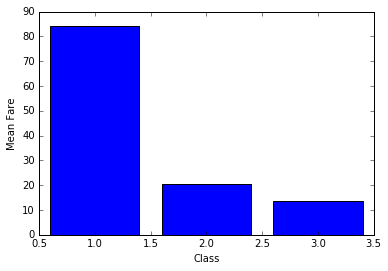

In [8]:
pclass_mean_far = titanic_data_org.groupby(['Pclass'])['Fare'].mean()
print pclass_mean_far

pclass = pclass_mean_far.index.get_level_values('Pclass')
mean_fares =  pclass_mean_far.values

#print pclass
#print mean_fares
plt.bar(pclass,mean_fares,align='center')
plt.ylabel('Mean Fare')
plt.xlabel('Class')


On an average , passengers paid about 
$84.15 for class 1 
$20.66 for class 2 
$13.68 for class 3

The average fare paid for pclass1 is about 6 times more than the average fares paid for pclass3

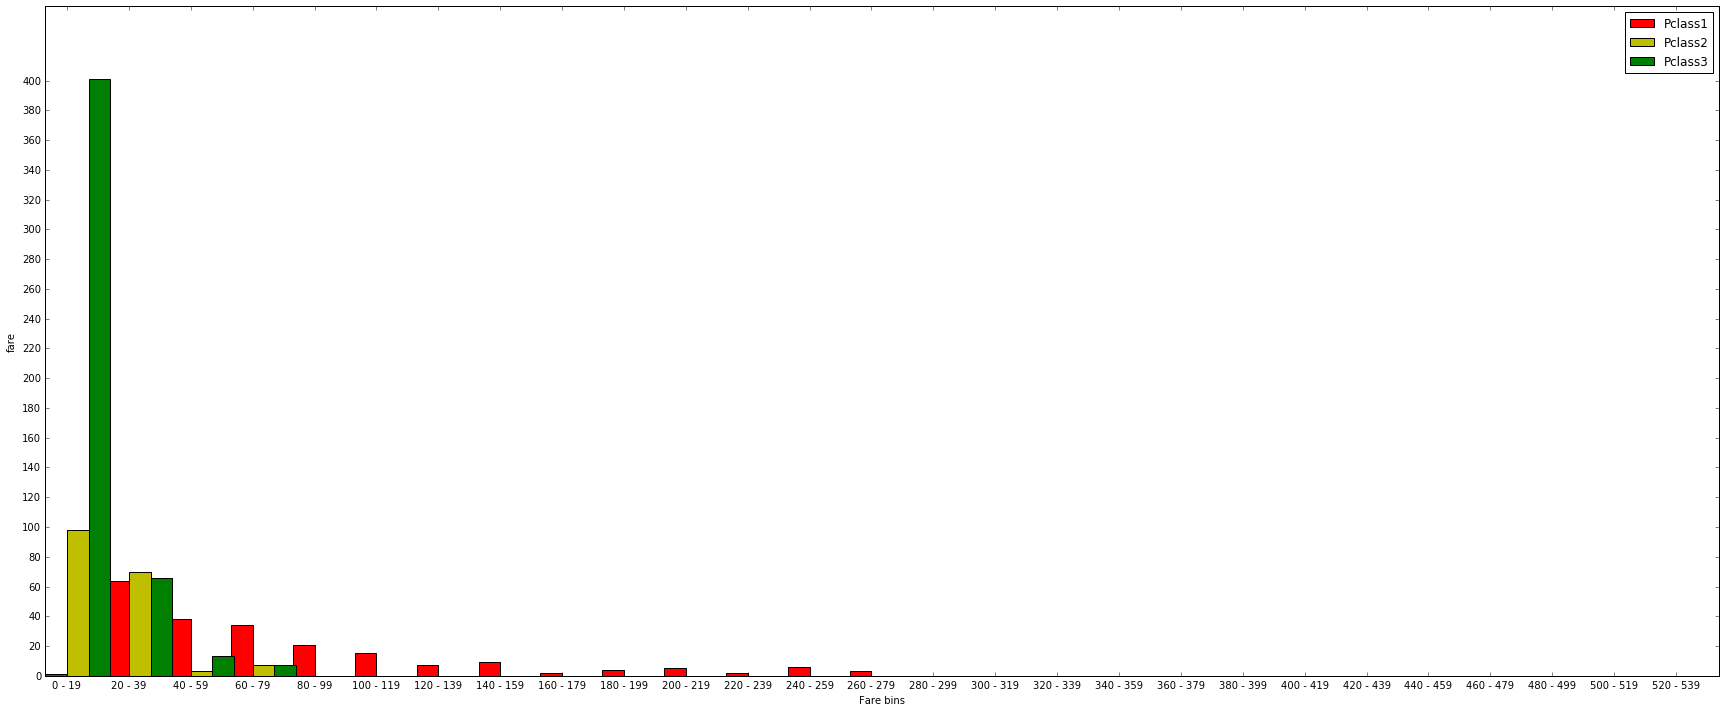

In [9]:
max_fares = titanic_data_org.groupby(['Pclass'])['Fare'].max()

#distribution of fares for pclass 1
p1_labels = [ "{0} - {1}".format(i, i + 19) for i in range(0, int(math.ceil(max_fares.loc[1])+20), 20) ]
titanic_data['fare_group']=pd.cut(titanic_data['Fare'], range(0,int(math.ceil(max_fares.loc[1]))+40, 20), right=True,
                                  labels=p1_labels)


#categorical index is a categorial index
pclass_fare_count = titanic_data.groupby(['Pclass','fare_group']).size()


for index in  p1_labels:
    if index not in pclass_fare_count.loc[2].index.get_level_values('fare_group').get_values():
        pclass_fare_count.loc[2,index]=0
    if index not in pclass_fare_count.loc[1].index.get_level_values('fare_group').get_values():
        pclass_fare_count.loc[1,index]=0
    if index not in pclass_fare_count.loc[3].index.get_level_values('fare_group').get_values():
        pclass_fare_count.loc[3,index]=0

        
fig, ax = plt.subplots(figsize=(30,12))
ax.set_xticklabels(p1_labels)
width=0.35
ax.set_xticks( np.arange(27) + width)

rects1 = ax.bar(np.arange(27), pclass_fare_count.loc[1].values, width, color='r')
rects2 = ax.bar(np.arange(27) + width,pclass_fare_count.loc[2].values, width, color='y')
rects3 = ax.bar(np.arange(27) + 2*width,pclass_fare_count.loc[3].values, width, color='g')
dummy = plt.yticks(np.arange(0, pclass_fare_count.values.max(), 20))
ax.legend((rects1[0], rects2[0],rects3[0]), ('Pclass1', 'Pclass2', 'Pclass3'))
plt.xlabel("Fare bins")
plt.ylabel("fare")

#plt.show()


What was the distribution of surival rate based on embarkment and class ?

In [10]:
emd_data = titanic_data_org.groupby(['Embarked','Survived']).size()
for value in emd_data.index.get_level_values('Embarked').unique():
    print("Survival rate of people who embarked from {} is {}%".format(value, (emd_data.ix[value][1] * 100) / ( emd_data.ix[value][0] + emd_data.ix[value][1])))



Survival rate of people who embarked from C is 55%
Survival rate of people who embarked from Q is 38%
Survival rate of people who embarked from S is 33%



Survial distribution 

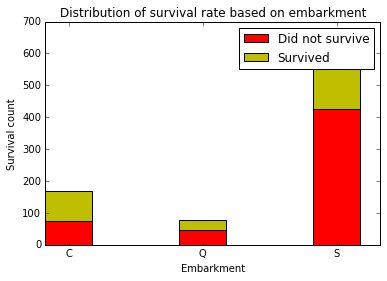

In [11]:
emd_data.loc[:,0].index.values    
ind = np.arange(3)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, emd_data.loc[:,0].values , width, color='r')
p2 = plt.bar(ind, emd_data.loc[:,1].values, width, color='y', bottom=emd_data.loc[:,0].values)

plt.ylabel('Survival count')
plt.xlabel('Embarkment')

plt.title('Distribution of survival rate based on embarkment')
plt.xticks(ind + width/2., emd_data.loc[:,0].index.values)
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Did not survive', 'Survived'))

plt.show()


It looks like most of the people who survived embarked from C . Though it is not possible to draw a conclusion with it, adding another parameter might help bring in a perspective.



Pclass distribution of survival

In [12]:
pclass_data = titanic_data_org.groupby(['Pclass','Survived']).size()
print pclass_data.loc
for value in pclass_data.index.get_level_values('Pclass').unique():
    print("Survival rate of people who stayed in class  {} is {}%".format(value, (pclass_data.ix[value][1] * 100) / ( pclass_data.ix[value][0] + pclass_data.ix[value][1])))


Survival rate of people who stayed in class  1 is 62%
Survival rate of people who stayed in class  2 is 47%
Survival rate of people who stayed in class  3 is 24%


It looks like most of the people who survived were from Pclass1 . It could be because they had easier access to the lifeboats and made their way through it easily. 



What factors made people more likely to survive?

To do this, we can look at the few dimensions and see the probability of survival vs non-survival 

In [17]:
titanic_data_org.groupby(['Sex','Survived','Pclass']).size().groupby(level=0).apply(lambda x: x/float(x.sum()))

Sex     Survived  Pclass
female  0         1         0.009554
                  2         0.019108
                  3         0.229299
        1         1         0.289809
                  2         0.222930
                  3         0.229299
male    0         1         0.133449
                  2         0.157712
                  3         0.519931
        1         1         0.077990
                  2         0.029463
                  3         0.081456
dtype: float64

Females suvived more than men . It could be because the men tried to help female passengers to escape.
Amongst the females, pclass1 passengers had a better chance of survival. There is also an interesting point here is that, the survival chance of men from pclass 3 is more than pclass2 or pclass1. It could be because men from pclass1 and pclass2 had children and women who they tried helping to escape before them . 